In [1]:
import numpy as np
from xml.etree import ElementTree
import cv2
from PIL import Image
import tensorflow as tf
import csv
import argparse
import os

In [2]:
#parser = argparse.ArgumentParser()
#parser.add_argument("deeplab", help="path_to_deeplab_frozen.pb", type=str)
#parser.add_argument("imageDIR", help="path_to_imageDIR", type=str)
#parser.add_argument("xmls", help="path_to_outputXMLDir", type=str)
#parser.add_argument("outCsvName", help="path_to_outputCsvName", type=str)
#parser.add_argument("option", help="use_whiteline or use_segmaps or use_const", type=str)
#args = parser.parse_args()

#この部分はnotebookでは不実装

In [3]:
#image_path = args.imageDIR
#xmls_path = args.xmls
#model_path = args.deeplab
#csv_name = args.outCsvName
#option = args.option

#この部分はnotebookでは不実装

In [4]:
image_path = '/Users/gosato/Desktop/画像/緑区ルート2/img'
xmls_path = "/Users/gosato/Desktop/画像/annotations/xmls/緑区ルート2"
model_path = "./bonnet_graph.pb"
csv_name = "緑区ルート2.csv"
option = "use_segmaps"

In [5]:
file_names=[]
for file in os.listdir(image_path):
    # ファイルのみ、拡張子なしで取得
    if os.path.isfile(os.path.join(image_path, file)):
        file_names.append(os.path.basename(file))

In [6]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 300
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, frozen_path):
        self.graph = tf.Graph()
        graph_def = None
        with open(frozen_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

    def returnSize(self, image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        return target_size

In [7]:
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.
    Returns:
      A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap

In [8]:
def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.
    Args:
      label: A 2D array with integer type, storing the segmentation label.
    Returns:
      result: A 2D array with floating type. The element of the array
        is the color indexed by the corresponding element in the input label
        to the PASCAL color map.
    Raises:
      ValueError: If label is not of rank 2 or its value is larger than color
        map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [9]:
def get_segmentation(i):
    image_file = image_path + "/" + file_names[i]
    img_path = image_file

    # load model
    model = DeepLabModel(model_path)

    # read image
    original_im = Image.open(img_path)

    # inferences DeepLab model
    resized_im, seg_map = model.run(original_im)

    return seg_map

In [10]:
def get_all_segmentation():
    seg_maps = []
    for i in range(0, len(file_names)):
        seg_map = get_segmentation(i)
        seg_maps.append(seg_map)
        print(str(file_names[i]) + ": "+ str(i) + "/" + str(len(file_names)))
    return seg_maps

In [11]:
def make_lines(minLineLength, maxLineGap):
    lines = []
    for i in range(0, len(file_names)):
        image_file = image_path + "/" + file_names[i]
        # print(i)
        # print(image_file)
        img = cv2.imread(image_file)
        img = cv2.resize(img, (600, 600))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        # edges = cv2.Canny(gray,300,500,apertureSize = 3)
        # これだと検出不能！！
        # 本当はここの変更を自動化したい

        line = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 360, threshold=100, minLineLength=minLineLength,
                               maxLineGap=maxLineGap)
        if line is None:
            lines.append([])
        else:
            lines.append(line)
    return lines

In [12]:
def check_in_road(x, y, seg_map, width=1):
    seg_map_x_len = len(seg_map)
    seg_map_y_len = len(seg_map[0])

    if (x // 2 - width) < 0:
        x_min = 0
    else:
        x_min = x // 2 - width

    if (y // 2 - width) < 0:
        y_min = 0
    else:
        y_min = y // 2 - width

    if (x // 2 + width) > seg_map_x_len:
        x_max = seg_map_x_len
    else:
        x_max = x // 2 + width

    if (y // 2 + width) > seg_map_y_len:
        y_max = seg_map_y_len
    else:
        y_max = y // 2 + width

    for p in range(x_min, x_max):
        for q in range(y_min, y_max):
            if seg_map[q, p] == 7:
                return True

    return False

In [13]:
def trapezoid_score(x_top_left, x_top_right, x_bottom_left, x_bottom_right, y_top, y_bottom):
    height_of_trapezoid = y_bottom - y_top
    # score=size_of_trapezoid(x_top_left,x_top_right,x_bottom_left,x_bottom_right,y_top,y_bottom)
    score = size_of_trapezoid(x_top_left, x_top_right, x_bottom_left, x_bottom_right, y_top, y_bottom) + (
                height_of_trapezoid ** 2)

    return score

In [14]:
def size_of_trapezoid(x_top_left, x_top_right, x_bottom_left, x_bottom_right, y_top, y_bottom):
    # 台形の面積を求める
    top_length = x_top_right - x_top_left
    bottom_length = x_bottom_right - x_bottom_left
    height_of_trapezoid = y_bottom - y_top
    size = (top_length + bottom_length) * height_of_trapezoid / 2
    return size

In [15]:
def decide_left_and_right_lines(lines):
    # 適切な台形がない場合は前の画像のものが使い回される
    left_lines = []
    right_lines = []
    sizes = []

    init_left_line = [(0, 1, 2, 3)]
    init_right_line = [(0, 1, 2, 3)]
    init_size = 0
    temp_left_line = init_left_line
    temp_right_line = init_right_line
    temp_size = init_size

    for i in range(0, len(file_names)):

        temp_lines = lines[i]

        if i == 0:
            temp_already_changed = False
        else:
            temp_left_line = left_lines[i - 1]
            temp_right_line = right_lines[i - 1]
            temp_size = 0
            temp_already_changed = False

        right_up_lines = choose_right_up_lines(temp_lines, i)

        right_down_lines = choose_right_down_lines(temp_lines, i)

        for j in range(0, len(right_up_lines)):
            for k in range(0, len(right_down_lines)):

                check_left_line = right_up_lines[j]
                check_right_line = right_down_lines[k]

                if temp_already_changed:

                    x1, y1, x2, y2 = check_left_line[0]
                    x3, y3, x4, y4 = check_right_line[0]
                    x5, y5, x6, y6 = temp_left_line[0]
                    x7, y7, x8, y8 = temp_right_line[0]

                    len_left_new = ((x2 - x1) ** 2 + (y2 - y1) ** 2)
                    len_right_new = ((x4 - x3) ** 2 + (y4 - y3) ** 2)
                    len_left_temp = ((x6 - x5) ** 2 + (y6 - y5) ** 2)
                    len_right_temp = ((x8 - x7) ** 2 + (y8 - y7) ** 2)

                    if y2 <= y3:
                        if y1 <= y4:
                            y_top = y3
                            y_bottom = y1
                            x_top_left = int(x1 + (x2 - x1) * ((y3 - y1) / (y2 - y1)))
                            x_top_right = x3
                            x_bottom_left = x1
                            x_bottom_right = int(x3 + (x4 - x3) * ((y1 - y3) / (y4 - y3)))
                        else:
                            y_top = y3
                            y_bottom = y4
                            x_top_left = int(x1 + (x2 - x1) * ((y3 - y1) / (y2 - y1)))
                            x_top_right = x3
                            x_bottom_left = int(x1 + (x2 - x1) * ((y4 - y1) / (y2 - y1)))
                            x_bottom_right = x4
                    else:
                        if y1 <= y4:
                            y_top = y2
                            y_bottom = y1
                            x_top_left = x2
                            x_top_right = int(x3 + (x4 - x3) * ((y2 - y3) / (y4 - y3)))
                            x_bottom_left = x1
                            x_bottom_right = int(x3 + (x4 - x3) * ((y1 - y3) / (y4 - y3)))
                        else:
                            y_top = y2
                            y_bottom = y4
                            x_top_left = x2
                            x_top_right = int(x3 + (x4 - x3) * ((y2 - y3) / (y4 - y3)))
                            x_bottom_left = int(x1 + (x2 - x1) * ((y4 - y1) / (y2 - y1)))
                            x_bottom_right = x4

                    check_size = trapezoid_score(x_top_left, x_top_right, x_bottom_left, x_bottom_right, y_top,
                                                 y_bottom)

                    if ((y_bottom - y_top) > 100 and (x_top_right - x_top_left) > 1 and (
                            x_bottom_right - x_bottom_left) > ((x_top_right - x_top_left) + 10)):
                        if check_size > temp_size:
                            temp_left_line = check_left_line
                            temp_right_line = check_right_line
                            temp_size = check_size



                else:

                    x1, y1, x2, y2 = check_left_line[0]
                    x3, y3, x4, y4 = check_right_line[0]
                    x5, y5, x6, y6 = temp_left_line[0]
                    x7, y7, x8, y8 = temp_right_line[0]

                    len_left_new = ((x2 - x1) ** 2 + (y2 - y1) ** 2)
                    len_right_new = ((x4 - x3) ** 2 + (y4 - y3) ** 2)
                    len_left_temp = ((x6 - x5) ** 2 + (y6 - y5) ** 2)
                    len_right_temp = ((x8 - x7) ** 2 + (y8 - y7) ** 2)

                    if y2 <= y3:
                        if y1 <= y4:
                            y_top = y3
                            y_bottom = y1
                            x_top_left = int(x1 + (x2 - x1) * ((y3 - y1) / (y2 - y1)))
                            x_top_right = x3
                            x_bottom_left = x1
                            x_bottom_right = int(x3 + (x4 - x3) * ((y1 - y3) / (y4 - y3)))
                        else:
                            y_top = y3
                            y_bottom = y4
                            x_top_left = int(x1 + (x2 - x1) * ((y3 - y1) / (y2 - y1)))
                            x_top_right = x3
                            x_bottom_left = int(x1 + (x2 - x1) * ((y4 - y1) / (y2 - y1)))
                            x_bottom_right = x4
                    else:
                        if y1 <= y4:
                            y_top = y2
                            y_bottom = y1
                            x_top_left = x2
                            x_top_right = int(x3 + (x4 - x3) * ((y2 - y3) / (y4 - y3)))
                            x_bottom_left = x1
                            x_bottom_right = int(x3 + (x4 - x3) * ((y1 - y3) / (y4 - y3)))
                        else:
                            y_top = y2
                            y_bottom = y4
                            x_top_left = x2
                            x_top_right = int(x3 + (x4 - x3) * ((y2 - y3) / (y4 - y3)))
                            x_bottom_left = int(x1 + (x2 - x1) * ((y4 - y1) / (y2 - y1)))
                            x_bottom_right = x4

                    check_size = trapezoid_score(x_top_left, x_top_right, x_bottom_left, x_bottom_right, y_top,
                                                 y_bottom)

                    if ((y_bottom - y_top) > 100 and (x_top_right - x_top_left) > 1 and (
                            x_bottom_right - x_bottom_left) > ((x_top_right - x_top_left) + 10)):
                        temp_left_line = check_left_line
                        temp_right_line = check_right_line
                        temp_size = check_size
                        temp_already_changed = True

        left_lines.append(temp_left_line)
        right_lines.append(temp_right_line)
        sizes.append(temp_size)

        # print(str(i)+"/"+str(len(lines)))

    left_lines = []
    right_lines = []
    sizes = []

    for i in range(0, len(file_names)):

        temp_lines = lines[i]

        if i == 0:
            temp_already_changed = False
        else:
            temp_left_line = left_lines[i - 1]
            temp_right_line = right_lines[i - 1]
            temp_size = 0
            temp_already_changed = False

        right_up_lines = choose_right_up_lines(temp_lines, i)
        right_down_lines = choose_right_down_lines(temp_lines, i)

        for j in range(0, len(right_up_lines)):
            for k in range(0, len(right_down_lines)):

                check_left_line = right_up_lines[j]
                check_right_line = right_down_lines[k]

                if temp_already_changed:

                    x1, y1, x2, y2 = check_left_line[0]
                    x3, y3, x4, y4 = check_right_line[0]
                    x5, y5, x6, y6 = temp_left_line[0]
                    x7, y7, x8, y8 = temp_right_line[0]

                    len_left_new = ((x2 - x1) ** 2 + (y2 - y1) ** 2)
                    len_right_new = ((x4 - x3) ** 2 + (y4 - y3) ** 2)
                    len_left_temp = ((x6 - x5) ** 2 + (y6 - y5) ** 2)
                    len_right_temp = ((x8 - x7) ** 2 + (y8 - y7) ** 2)

                    if y2 <= y3:
                        if y1 <= y4:
                            y_top = y3
                            y_bottom = y1
                            x_top_left = int(x1 + (x2 - x1) * ((y3 - y1) / (y2 - y1)))
                            x_top_right = x3
                            x_bottom_left = x1
                            x_bottom_right = int(x3 + (x4 - x3) * ((y1 - y3) / (y4 - y3)))
                        else:
                            y_top = y3
                            y_bottom = y4
                            x_top_left = int(x1 + (x2 - x1) * ((y3 - y1) / (y2 - y1)))
                            x_top_right = x3
                            x_bottom_left = int(x1 + (x2 - x1) * ((y4 - y1) / (y2 - y1)))
                            x_bottom_right = x4
                    else:
                        if y1 <= y4:
                            y_top = y2
                            y_bottom = y1
                            x_top_left = x2
                            x_top_right = int(x3 + (x4 - x3) * ((y2 - y3) / (y4 - y3)))
                            x_bottom_left = x1
                            x_bottom_right = int(x3 + (x4 - x3) * ((y1 - y3) / (y4 - y3)))
                        else:
                            y_top = y2
                            y_bottom = y4
                            x_top_left = x2
                            x_top_right = int(x3 + (x4 - x3) * ((y2 - y3) / (y4 - y3)))
                            x_bottom_left = int(x1 + (x2 - x1) * ((y4 - y1) / (y2 - y1)))
                            x_bottom_right = x4

                    check_size = trapezoid_score(x_top_left, x_top_right, x_bottom_left, x_bottom_right, y_top,
                                                 y_bottom)
                    if ((y_bottom - y_top) > 100 and (x_top_right - x_top_left) > 1 and (
                            x_bottom_right - x_bottom_left) > ((x_top_right - x_top_left) + 10)):
                        if check_size > temp_size:
                            temp_left_line = check_left_line
                            temp_right_line = check_right_line
                            temp_size = check_size




                else:

                    x1, y1, x2, y2 = check_left_line[0]
                    x3, y3, x4, y4 = check_right_line[0]
                    x5, y5, x6, y6 = temp_left_line[0]
                    x7, y7, x8, y8 = temp_right_line[0]

                    len_left_new = ((x2 - x1) ** 2 + (y2 - y1) ** 2)
                    len_right_new = ((x4 - x3) ** 2 + (y4 - y3) ** 2)
                    len_left_temp = ((x6 - x5) ** 2 + (y6 - y5) ** 2)
                    len_right_temp = ((x8 - x7) ** 2 + (y8 - y7) ** 2)

                    if y2 <= y3:
                        if y1 <= y4:
                            y_top = y3
                            y_bottom = y1
                            x_top_left = int(x1 + (x2 - x1) * ((y3 - y1) / (y2 - y1)))
                            x_top_right = x3
                            x_bottom_left = x1
                            x_bottom_right = int(x3 + (x4 - x3) * ((y1 - y3) / (y4 - y3)))
                        else:
                            y_top = y3
                            y_bottom = y4
                            x_top_left = int(x1 + (x2 - x1) * ((y3 - y1) / (y2 - y1)))
                            x_top_right = x3
                            x_bottom_left = int(x1 + (x2 - x1) * ((y4 - y1) / (y2 - y1)))
                            x_bottom_right = x4
                    else:
                        if y1 <= y4:
                            y_top = y2
                            y_bottom = y1
                            x_top_left = x2
                            x_top_right = int(x3 + (x4 - x3) * ((y2 - y3) / (y4 - y3)))
                            x_bottom_left = x1
                            x_bottom_right = int(x3 + (x4 - x3) * ((y1 - y3) / (y4 - y3)))
                        else:
                            y_top = y2
                            y_bottom = y4
                            x_top_left = x2
                            x_top_right = int(x3 + (x4 - x3) * ((y2 - y3) / (y4 - y3)))
                            x_bottom_left = int(x1 + (x2 - x1) * ((y4 - y1) / (y2 - y1)))
                            x_bottom_right = x4

                    check_size = trapezoid_score(x_top_left, x_top_right, x_bottom_left, x_bottom_right, y_top,
                                                 y_bottom)
                    if ((y_bottom - y_top) > 100 and (x_top_right - x_top_left) > 1 and (
                            x_bottom_right - x_bottom_left) > ((x_top_right - x_top_left) + 10)):
                        temp_left_line = check_left_line
                        temp_right_line = check_right_line
                        temp_size = check_size
                        temp_already_changed = True

        left_lines.append(temp_left_line)
        right_lines.append(temp_right_line)
        sizes.append(temp_size)

        # print(str(i)+"/"+str(len(lines)))

    return (left_lines, right_lines)

In [16]:
# TODO: ボンネットセグメンテーションを導入予定
def decide_bonnet():
    return 500

In [17]:
def decide_trapezoids(left_lines, right_lines,seg_maps, bonnet,option):
    trapezoids = []
    if option=="use_whiteline":
        for i in range(len(file_names)):
            x1, y1, x2, y2 = left_lines[i][0]
            x3, y3, x4, y4 = right_lines[i][0]
            if y2 <= y3:
                y_top = y3
                y_bottom = bonnet
                x_top_left = int(x1 + (x2 - x1) * ((y3 - y1) / (y2 - y1)))
                x_top_right = x3
                x_bottom_left = int(x1 + (x2 - x1) * ((bonnet - y1) / (y2 - y1)))
                x_bottom_right = int(x3 + (x4 - x3) * ((bonnet - y3) / (y4 - y3)))
            else:
                y_top = y2
                y_bottom = bonnet
                x_top_left = x2
                x_top_right = int(x3 + (x4 - x3) * ((y2 - y3) / (y4 - y3)))
                x_bottom_left = int(x1 + (x2 - x1) * ((bonnet - y1) / (y2 - y1)))
                x_bottom_right = int(x3 + (x4 - x3) * ((bonnet - y3) / (y4 - y3)))
            if (x_top_right - x_top_left <= 100):
                # print(i)
                while (x_top_right - x_top_left <= 100):
                    # print(i)
                    y_top += 1
                    x_top_left = int(x1 + (x2 - x1) * ((y_top - y1) / (y2 - y1)))
                    x_top_right = int(x3 + (x4 - x3) * ((y_top - y3) / (y4 - y3)))
                # 台形上部の幅は100より大きい
            trapezoids.append([x_top_left, x_top_right, x_bottom_left, x_bottom_right, y_top, y_bottom])
    if option=="use_segmaps":
        for i in range(len(file_names)):
            #どれくらいのピクセル幅から道路とみなすか
            min_width=300
            seg_map=seg_maps[i]
            temp_y_top=0
            temp_y_bottom=599
            #y_top,x_top_left,x_top_rightの決定
            while temp_y_top<599:
                number_of_road_cell=0
                #leftとして大きな初期値、rightとして小さな初期値を与える
                temp_x_top_left=9999
                temp_x_top_right=-9999
                for j in range(0,300):
                    if seg_map[temp_y_top//2,j]==7:
                        number_of_road_cell+=1
                        if (j*2)<temp_x_top_left:
                            temp_x_top_left=j*2
                        if (j*2+1)>temp_x_top_right:
                            temp_x_top_right=j*2+1
                else:
                    pass

                if number_of_road_cell>(min_width//2):
                    break
                else:
                    temp_y_top+=2
            #y_bottom,x_bottom_left,x_bottom_rightの決定
            while temp_y_bottom>0:
                number_of_road_cell=0
                temp_x_bottom_left=9999
                temp_x_bottom_right=-9999
                for k in range(0,300):
                    if seg_map[temp_y_bottom//2,k]==7:
                        number_of_road_cell+=1
                        if k*2<temp_x_bottom_left:
                            temp_x_bottom_left=k*2
                        if k*2+1>temp_x_bottom_right:
                            temp_x_bottom_right=k*2+1
                    else:
                        pass

                if number_of_road_cell>(min_width//2):
                    break
                else:
                    temp_y_bottom-=2
            trapezoid=[0,0,0,0,0,0]
            trapezoid[0]=temp_x_top_left
            trapezoid[1]=temp_x_top_right
            trapezoid[2]=temp_x_bottom_left
            trapezoid[3]=temp_x_bottom_right
            trapezoid[4]=temp_y_top
            trapezoid[5]=temp_y_bottom
            trapezoids.append(trapezoid)
    if option=="use_const":
        for i in range(len(file_names)):
            trapezoid=[50,529,20,579,300,599]
            trapezoids.append(trapezoid)
    return (trapezoids)

In [18]:
def search_point_grid(trapezoid, x_split, y_split, search_x, search_y):
    x_top_left = trapezoid[0]
    x_top_right = trapezoid[1]
    x_bottom_left = trapezoid[2]
    x_bottom_right = trapezoid[3]
    y_top = trapezoid[4]
    y_bottom = trapezoid[5]

    # (search_x,search_y)が台形のどの分割グリッドにあるか求める
    # 分割グリッドは左上から((0,0),(1,0)...(x_split-1,0)),(0,1),(1,1),...,(x_split-1,1)),...,((0,y_split-1),(1,y_split-1),...,(x_split-1,y_split-1))と並ぶ

    # y_resultとして許される最大値はy_split-1
    result_y_max = y_split - 1
    # グリッドのyの値を初期値0に設定
    result_y = 0
    while result_y <= result_y_max:
        # 現在のy_resultについてグリッドのy座標を決定する
        grid_top_y = y_top + (y_bottom - y_top) * ((result_y) / y_split)
        grid_bottom_y = y_top + (y_bottom - y_top) * ((result_y + 1) / y_split)
        if grid_top_y <= search_y < grid_bottom_y:
            break
        else:
            result_y += 1
        if result_y > result_y_max:
            # print("y is out of the trapezoid.")
            return (None)
        else:
            pass

    # search_yにおける台形の左端,右端のx座標を求める
    x_left = x_top_left + (x_bottom_left - x_top_left) * (search_y - y_top) / (y_bottom - y_top)
    x_right = x_top_right + (x_bottom_right - x_top_right) * (search_y - y_top) / (y_bottom - y_top)
    result_x = 0
    result_x_max = x_split - 1
    while result_x <= result_x_max:
        grid_left_x = x_left + (x_right - x_left) * ((result_x) / x_split)
        grid_right_x = x_left + (x_right - x_left) * ((result_x + 1) / x_split)
        if grid_left_x <= search_x < grid_right_x:
            break
        else:
            result_x += 1
        if result_x > result_x_max:
            # print("x is out of the trapezoid.")
            return (None)
        else:
            pass
    result_grid = (result_x, result_y)
    return result_grid

In [19]:
def crack_ratio_calculate(trapezoid, boundingboxes, x_split, y_split):
    result_D00_D10 = []
    # 重率0.6
    result_D20 = []
    # 重率1

    for i in range(0, len(boundingboxes)):

        xmin = boundingboxes[i][0]
        xmax = boundingboxes[i][1]
        ymin = boundingboxes[i][2]
        ymax = boundingboxes[i][3]
        class_of_damage = boundingboxes[i][4]

        x_temp = xmin
        y_temp = ymin

        result_D00_D10_temp = []
        result_D20_temp = []

        if class_of_damage == "D00":

            while y_temp <= ymax:
                while x_temp <= xmax:
                    grid_temp = search_point_grid(trapezoid, x_split, y_split, x_temp, y_temp)
                    if grid_temp == None:
                        pass
                    elif grid_temp in result_D00_D10_temp:
                        pass
                    else:
                        result_D00_D10_temp.append(grid_temp)
                    x_temp += 1
                y_temp += 1
                x_temp = xmin
        elif class_of_damage == "D10":

            while y_temp <= ymax:
                while x_temp <= xmax:
                    grid_temp = search_point_grid(trapezoid, x_split, y_split, x_temp, y_temp)
                    if grid_temp == None:
                        pass
                    elif grid_temp in result_D00_D10_temp:
                        pass
                    else:
                        result_D00_D10_temp.append(grid_temp)
                    x_temp += 1
                y_temp += 1
                x_temp = xmin
        elif class_of_damage == "D20":

            while y_temp <= ymax:
                while x_temp <= xmax:
                    grid_temp = search_point_grid(trapezoid, x_split, y_split, x_temp, y_temp)
                    if grid_temp == None:
                        pass
                    elif grid_temp in result_D20_temp:
                        pass
                    else:
                        result_D20_temp.append(grid_temp)
                    x_temp += 1
                y_temp += 1
                x_temp = xmin
        else:
            pass

        for j in range(0, len(result_D00_D10_temp)):
            grid_temp_2 = result_D00_D10_temp[j]

            if grid_temp_2 in result_D20:
                pass
            elif grid_temp_2 in result_D00_D10:
                result_D20.append(grid_temp_2)
                result_D00_D10.remove(grid_temp_2)
            else:
                result_D00_D10.append(grid_temp_2)

        for k in range(0, len(result_D20_temp)):
            grid_temp_3 = result_D20_temp[k]
            if grid_temp_3 in result_D20:
                pass
            elif grid_temp_3 in result_D00_D10:
                result_D20.append(grid_temp_3)
                result_D00_D10.remove(grid_temp_3)
            else:
                result_D20.append(grid_temp_3)

    # print("重率0.6のグリッドは"+str(result_D00_D10)+"の"+str(len(result_D00_D10))+"箇所です")
    # print("重率1のグリッドは"+str(result_D20)+"の"+str(len(result_D20))+"箇所です")
    crack_ratio = (0.6 * len(result_D00_D10) + len(result_D20)) / (x_split * y_split)
    return crack_ratio

In [20]:
def boundingboxes(i):
    img = cv2.imread(image_path + "/" + file_names[i])
    infile_xml = open(xmls_path + "/" + file_names[i].split('.')[0] + '.xml')

    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()

    boundingboxes = []

    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(int(xmlbox.find('xmin').text))
        xmax = int(int(xmlbox.find('xmax').text))
        ymin = int(int(xmlbox.find('ymin').text))
        ymax = int(int(xmlbox.find('ymax').text))
        boundingboxes.append([xmin, xmax, ymin, ymax, cls_name])

    return boundingboxes

In [21]:
def crack_ratio(trapezoids, i, x_split, y_split):
    temp = boundingboxes(i)
    trapezoid = trapezoids[i]

    crack_ratio = crack_ratio_calculate(trapezoid, temp, x_split, y_split)

    return crack_ratio

In [22]:
def save_crack_ratio():
    result = []
    for i in range(len(file_names)):
        result.append(crack_ratio(trapezoids, i, x_split, y_split))
    return result

In [23]:
def make_csv(crack_ratios):
    with open(csv_name, 'a') as f:
        writer = csv.writer(f)
        writer.writerow(["file_name", "crack_ratio"])
        for i in range(len(file_names)):
            file_name = file_names[i]
            crack_ratio = crack_ratios[i]
            writer.writerow([file_name, crack_ratio])

In [24]:
# segmentationの結果を取得
LABEL_NAMES = np.full(150, "other")
LABEL_NAMES[7] = "road"
LABEL_NAMES[12] = "pavement"
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


In [25]:

# TODO: deeplabの出力で置き換え予定
bonnet = decide_bonnet()




In [26]:
# road segmentation
seg_maps = get_all_segmentation()

20200119112113809_140.278486_35.524413.jpg: 0/273
20200119112425598_140.280137_35.525012.jpg: 1/273
20200119111803041_140.263294_35.521788.jpg: 2/273
20200119112429431_140.279891_35.524960.jpg: 3/273
20200119112133855_140.280273_35.525220.jpg: 4/273
20200119112316174_140.280533_35.525200.jpg: 5/273
20200119112019440_140.272277_35.521726.jpg: 6/273
20200119111750639_140.261649_35.522338.jpg: 7/273
20200119112125278_140.279345_35.524802.jpg: 8/273
20200119111803977_140.263406_35.521770.jpg: 9/273
20200119111917962_140.268383_35.521697.jpg: 10/273
20200119112321755_140.280444_35.525045.jpg: 11/273
20200119111920816_140.268616_35.521704.jpg: 12/273
20200119111955503_140.269158_35.521701.jpg: 13/273
20200119112311418_140.280785_35.525383.jpg: 14/273
20200119112216416_140.281125_35.525653.jpg: 15/273
20200119111917022_140.268294_35.521694.jpg: 16/273
20200119111813514_140.264174_35.521707.jpg: 17/273
20200119112110914_140.278359_35.524356.jpg: 18/273
20200119111809718_140.263905_35.521715.jp

20200119112306663_140.280625_35.525667.jpg: 160/273
20200119111732414_140.259478_35.523042.jpg: 161/273
20200119111738132_140.260005_35.522853.jpg: 162/273
20200119112137677_140.280522_35.525340.jpg: 163/273
20200119112016550_140.271859_35.521695.jpg: 164/273
20200119111806834_140.263710_35.521734.jpg: 165/273
20200119112424642_140.280183_35.524995.jpg: 166/273
20200119112055655_140.276903_35.523686.jpg: 167/273
20200119112120494_140.278915_35.524614.jpg: 168/273
20200119112004112_140.270320_35.521683.jpg: 169/273
20200119111723805_140.259493_35.523364.jpg: 170/273
20200119111845497_140.264682_35.521702.jpg: 171/273
20200119111735275_140.259695_35.522961.jpg: 172/273
20200119112135754_140.280453_35.525310.jpg: 173/273
20200119112012757_140.271455_35.521693.jpg: 174/273
20200119111744854_140.260941_35.522569.jpg: 175/273
20200119112103299_140.277774_35.524091.jpg: 176/273
20200119112001217_140.269911_35.521686.jpg: 177/273
20200119111808762_140.263905_35.521715.jpg: 178/273
202001191117

In [27]:
def choose_right_up_lines(lines, i, dx_min=30, dy_min=30, im_height=600, im_width=600, seg_maps=seg_maps):
    right_up_lines = []
    seg_map = seg_maps[i]
    hoo = 0
    while hoo < len(lines):

        x1, y1, x2, y2 = lines[hoo][0]

        if ((x2 - x1) > dx_min and (y2 - y1) < (-1) * dy_min):
            # 直線は少しは右上がりである

            if check_in_road(x1, y1, seg_map):
                # 左下の点が道路領域に入っている
                # まずはx1=0となるように延長
                new_x1 = 0
                new_y1 = int(y2 + (y1 - y2) * (x2 / (x2 - x1)))
                if new_y1 >= 600:
                    # y>=600になってしまった場合はy=599で止める
                    new_y1 = 599
                    new_x1 = int((x2 - (x2 - x1) * ((599 - y2) / (y1 - y2))))

                if check_in_road(x2, y2, seg_map):

                    # 右上の点が道路領域に入っている
                    # 直線を延長する
                    dx2 = 10
                    new_x2 = x2
                    new_y2 = y2
                    while (new_y2 > 100 and new_x2 < 500):

                        # new_y2すなわち右上点のy座標はは100より大きい
                        # 右上点のx座標は500よりは小さい
                        new_x2_next = new_x2 + dx2

                        new_y2_next = int(y1 - (y1 - y2) * ((new_x2_next - x1) / (x2 - x1)))
                        if check_in_road(new_x2_next, new_y2_next, seg_map):

                            new_x2 = new_x2_next
                            new_y2 = new_y2_next
                        else:
                            break

                else:
                    # 右上の点が道路領域に入っていない
                    # 直線を短くする

                    dx2 = 10
                    new_x2 = x2
                    new_y2 = y2
                    while new_x2 > (new_x1 + dx_min):
                        # new_x2すなわち右上点のx座標はnew_x1+dx_minより小さくならない
                        new_x2_next = new_x2 - dx2
                        new_y2_next = int(y1 - (y1 - y2) * ((new_x2_next - x1) / (x2 - x1)))
                        if check_in_road(new_x2_next, new_y2_next, seg_map):
                            new_x2 = new_x2_next
                            new_y2 = new_y2_next
                        else:
                            break

                # 確定
                x1, y1, x2, y2 = new_x1, new_y1, new_x2, new_y2
                hoo += 1



            else:
                # 左下の点が道路領域に入っていない

                hoo += 1
        else:
            # 直線は右上がりではない
            hoo += 1

        if (x2 - x1) > (dx_min):
            if (y2 - y1) < (-1) * (dy_min):
                right_up_lines.append([[x1, y1, x2, y2]])

    return right_up_lines

In [28]:
def choose_right_down_lines(lines, i, dx_min=30, dy_min=30, seg_maps=seg_maps):
    right_up_lines = []
    seg_map = seg_maps[i]
    hoo = 0
    while hoo < len(lines):
        x1, y1, x2, y2 = lines[hoo][0]

        if ((x2 - x1) > dx_min and (y2 - y1) > dy_min):
            # 直線は少しは右下がりである
            if check_in_road(x2, y2, seg_map):
                # 右下の点が道路領域に入っている
                # まずはx2=599となるように延長
                new_x2 = 599
                new_y2 = int(y1 + (y2 - y1) * ((599 - x1) / (x2 - x1)))
                if new_y2 >= 600:
                    # y>=600になってしまった場合はy=599で止める
                    new_y2 = 599
                    new_x2 = int((x1 + (x2 - x1) * ((599 - y1) / (y2 - y1))))

                if check_in_road(x1, y1, seg_map):
                    # 左上の点が道路領域に入っている
                    # 直線を延長する

                    dx1 = 10
                    new_x1 = x1
                    new_y1 = y1
                    while (new_y1 > 100 and new_x1 > 100):

                        new_x1_next = new_x1 - dx1
                        new_y1_next = int(y1 - (y2 - y1) * ((x1 - new_x1_next) / (x2 - x1)))
                        if check_in_road(new_x1_next, new_y1_next, seg_map):
                            new_x1 = new_x1_next
                            new_y1 = new_y1_next
                        else:
                            break

                else:
                    # 左上の点が道路領域に入っていない
                    # 直線を短くする

                    dx1 = 10
                    new_x1 = x1
                    new_y1 = y1
                    while new_x2 > (new_x1 + dx_min):
                        new_x1_next = new_x1 + dx1
                        new_y1_next = int(y2 - (y2 - y1) * ((x2 - new_x1_next) / (x2 - x1)))

                        if check_in_road(new_x1_next, new_y1_next, seg_map):
                            new_x1 = new_x1_next
                            new_y1 = new_y1_next
                        else:
                            break

                # 確定
                x1, y1, x2, y2 = new_x1, new_y1, new_x2, new_y2
                hoo += 1

            else:
                # 右下の点が道路領域にない

                hoo += 1
        else:

            hoo += 1

        if (x2 - x1) > (dx_min):
            if (y2 - y1) > 1 * (dy_min):
                right_up_lines.append([[x1, y1, x2, y2]])

    return right_up_lines

In [29]:
# ハフ変換のパラメータ（佐藤くん選択）
minLineLength = 100
maxLineGap = 3

In [30]:
# ハフ変換で検出した直線のリスト（直線の始点と終点）
lines = make_lines(minLineLength, maxLineGap)

In [31]:
# linesの中からベストな区画線を抽出（道路領域に含まれる、右上がり・左下がり、台形面積と台形高さの2乗の和が最大）
left_lines, right_lines = decide_left_and_right_lines(lines)

In [32]:
# 台形の頂点を決定（改善の余地あり）
trapezoids = decide_trapezoids(left_lines, right_lines,seg_maps, bonnet=bonnet,option=option)



In [33]:
# 台形の分割数 TODO: depth predictionの結果を活用
x_split = 10
y_split = 10

In [34]:
# ひび割れ率の計算をする
crack_ratios = save_crack_ratio()

In [35]:
# 出力
make_csv(crack_ratios)

# 以下実験用

## セグメンテーションの閲覧

In [36]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

In [37]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 300
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, frozen_path):
        self.graph = tf.Graph()
        graph_def = None
        with open(frozen_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

    def returnSize(self, image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        return target_size

In [38]:
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
      A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap

In [39]:
def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
      label: A 2D array with integer type, storing the segmentation label.

    Returns:
      result: A 2D array with floating type. The element of the array
        is the color indexed by the corresponding element in the input label
        to the PASCAL color map.

    Raises:
      ValueError: If label is not of rank 2 or its value is larger than color
        map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [40]:
def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

In [41]:
def show_segmentation(i):
    #見たい画像のパス    
    image_file = image_path + "/" + file_names[i]
    img_path = image_file

    #deeplab_graph.pbの位置
    model_path = "./deeplab_graph.pb"
    #model_path = "./bonnet_graph.pb"

    # load model
    model = DeepLabModel(model_path)

    # read image
    original_im = Image.open(img_path)

    # inferences DeepLab model
    resized_im, seg_map = model.run(original_im)
    
    # show inference result
    vis_segmentation(resized_im, seg_map)

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


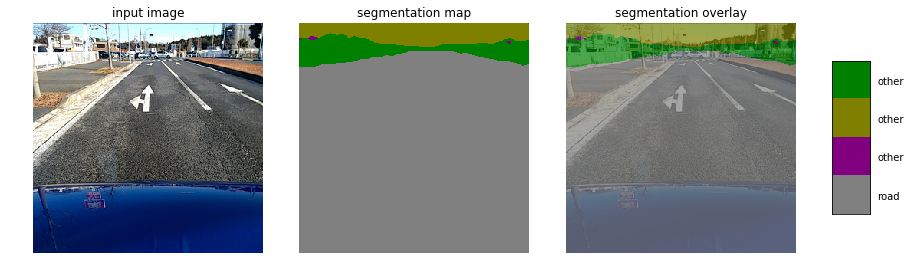

In [42]:
show_segmentation(4)

## 台形の可視化

In [43]:
def draw_images_2(trapezoids,x_split,y_split,i):
    #台形に加え、傷の位置、種類も表示するコード
    img = cv2.imread(image_path + "/" + file_names[i])
    infile_xml = open(xmls_path + "/" + file_names[i].split('.')[0] + '.xml')
    
    
    trapezoid=trapezoids[i]
    
    
    img = cv2.resize(img,(600,600))
                      
    x_top_left=trapezoid[0]
    x_top_right=trapezoid[1]
    x_bottom_left=trapezoid[2]
    x_bottom_right=trapezoid[3]
    y_top=trapezoid[4]
    y_bottom=trapezoid[5]
    
    pts = np.array([[x_top_left,y_top],[x_bottom_left,y_bottom],[x_bottom_right,y_bottom],[x_top_right,y_top]])
    
    cv2.polylines(img,[pts],True,(0,255,255),2)
    
    pts2=[]
    
    #grid_xとして許される最大値はx_split-1
    grid_x_max=x_split-1
    #グリッドのxの値を初期値1に設定
    grid_x=1
    
    while grid_x<=grid_x_max:
        #現在のgrid_xについてグリッド上下端の座標を決定する
        x_top_line=int(x_top_left+(x_top_right-x_top_left)*(grid_x/x_split))
        x_bottom_line=int(x_bottom_left+(x_bottom_right-x_bottom_left)*(grid_x/x_split))
        pts2.append([[x_top_line,y_top],[x_bottom_line,y_bottom]])
        grid_x+=1
 
    grid_y_max=y_split-1
    grid_y=1
    
    while grid_y<=grid_y_max:
        
        x_left_line=int(x_top_left+(x_bottom_left-x_top_left)*(grid_y/y_split))
        x_right_line=int(x_top_right+(x_bottom_right-x_top_right)*(grid_y/y_split))
        y_line=int(y_top+(y_bottom-y_top)*(grid_y/y_split))
        pts2.append([[x_left_line,y_line],[x_right_line,y_line]])
        grid_y+=1
    
    for line in pts2:
        
        line=np.array(line)
        cv2.polylines(img,[line],True,(0,255,255),2)
    
    #ここをどうするか？
    
    

    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    
    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(int(xmlbox.find('xmin').text)/720*600)
        xmax = int(int(xmlbox.find('xmax').text)/720*600)
        ymin = int(int(xmlbox.find('ymin').text)/720*600)
        ymax = int(int(xmlbox.find('ymax').text)/720*600)

        font = cv2.FONT_HERSHEY_SIMPLEX

        # put text
        cv2.putText(img,cls_name,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)

        # draw bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0),3)
                      

    
    
    return img

In [44]:
def make_output_images():
    for i in range(0,len(file_names)):   
        img = draw_images_2(trapezoids,x_split,y_split,i)
        cv2.imwrite("output_"+ "_"+str(i)+".jpg", img)

In [45]:
make_output_images()
#画像を保存